In [2]:
import os
os.chdir("/kaggle/input/omniglot/")

In [3]:
import numpy as np
import cv2
import tqdm
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision

In [4]:
class DataLoader():
    def read_characters(self, dataset_directory, script_directory):
        image_data = []
        image_tag = []
        characters = os.listdir(os.path.join(dataset_directory, script_directory))
        
        for char in characters:
            images = os.listdir(os.path.join(dataset_directory,script_directory,char))

            for img in images:
                try:
                    img_path = os.path.join(dataset_directory,script_directory,char,img)
                    img_array = cv2.resize(cv2.imread(img_path),(28,28))
                    
                    img_rotated_90 = cv2.rotate(img_array, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img_array, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img_array, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    # print(img_path)
                    
                    image_data.extend((img_array, img_rotated_90, img_rotated_180, img_rotated_270))
                    image_tag.extend((
                        script_directory+"_"+char+"_"+"0",
                        script_directory+"_"+char+"_"+"90",
                        script_directory+"_"+char+"_"+"180",
                        script_directory+"_"+char+"_"+"270"
                    ))
                except AssertionError as error:
                    print(error)
        return np.array(image_data), np.array(image_tag)

    def read_images(self, dataset_directory):
        pool = mp.Pool(mp.cpu_count())
        scripts_list = os.listdir(dataset_directory)
        
        results = [pool.apply(self.read_characters, args=(dataset_directory, scripts)) for scripts in scripts_list]
        pool.close()

        img_array = None
        img_tag = None

        for result in results:
            if img_array is None:
                img_array = result[0]
                img_tag = result[1]
            else:
                img_array = np.vstack([img_array, result[0]])
                img_tag = np.concatenate([img_tag, result[1]])
        return img_array, img_tag

    def extract_sample(self, n_way, n_shot, n_query, img_array, img_tag):
        sample = []
        K = np.random.choice(np.unique(img_tag), n_way, replace=False)
        
        for cls in K:
            img_cls = img_array[img_tag == cls] # Choosing img with particular class
            perm = np.random.permutation(img_cls) # Permuting them
            sample_cls = perm[:(n_shot+n_query)] # Picking Support and Query images
            sample.append(sample_cls)
        
        sample = np.array(sample)
        sample = torch.from_numpy(sample).float()
        sample = sample.permute(0,1,4,2,3) # reordering the images
        
        # print(sample.shape)
        return({
            'images': sample,
            'n_way': n_way,
            'n_shot': n_shot,
            'n_query': n_query
            })

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.encoder()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def encoder(self):
        self.encode = nn.Sequential(
            self.conv_block(3,64),
            self.conv_block(64,64),
            self.conv_block(64,64),
            self.conv_block(64,64),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encode(x)

In [46]:
class Adaptive_Subspace(nn.Module):
    def __init__(self, Encoder):
        super(Adaptive_Subspace, self).__init__()
        self.Encoder = Encoder.cuda()

    def Distance_Metric(self, x, y, mean):
        # x is a 3d matrix of each support units embedding-> (n_way)x(n_shot)x(d)
        # y is a 3d matrix of each subspace -> (n_way)x(d)x(n)
        # To Return: Distance Metric of each point to subspace
        # i.e. (n_way)x(n_shot)x(n_way)
        
        n_way = x.size(0)
        n_shot = x.size(1)
        d = y.size(1)
        
        similarity_matrix = []
        discriminative_loss = 0.0
        
        for i in range(n_way):
            hyperplane = y[i]
            M = torch.mm(hyperplane,torch.transpose(hyperplane,0,1))
            I = torch.eye(hyperplane.shape[0]).cuda()
            mult = I-M
            mean_matrix = mean[i].unsqueeze(0).unsqueeze(0).expand(n_way, n_shot, d)
            targ_matrix = x - mean_matrix
            
            mult = mult.unsqueeze(0).expand(n_way,d,d)
            distance_matrix = torch.bmm(targ_matrix,torch.transpose(mult,1,2))
            distance_matrix = torch.sum(distance_matrix * distance_matrix, dim=-1)
            
            similarity_matrix.append(distance_matrix)
        
        similarity = torch.stack(similarity_matrix, dim=2)
            
        for i in range(n_way):
            for j in range(n_way):
                if i!=j:
                    temp_loss = torch.mm(torch.transpose(y[i],0,1),y[j])
                    discriminative_loss += torch.sum(temp_loss*temp_loss)
                    
        return similarity, discriminative_loss
        
            
    def forward_loss(self, episode, n):
        images = episode['images'].cuda()
        n_way = episode['n_way']
        n_shot = episode['n_shot']
        n_query = episode['n_query']

        img_support = images[:, :n_shot]
        img_query = images[:, n_shot:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds.cuda()
        target_inds = target_inds.squeeze(-1).view(n_way*n_query)
        
        # encode images of the support and the query set
        x = torch.cat([img_support.contiguous().view(n_way * n_shot, *img_support.size()[2:]),
                       img_query.contiguous().view(n_way * n_query, *img_query.size()[2:])], 0)
    
        z = self.Encoder.forward(x)
        z_dim = z.size(-1) # usually 64
        z_matrix = z[:n_way*n_shot].view(n_way, n_shot, z_dim)
        
        z_query_matrix = z[n_way*n_shot:].view(n_way, n_query, z_dim).cuda()
        
        z_mean_normal = z_matrix.mean(1)
        z_mean = z_mean_normal.unsqueeze(1).expand(n_way, n_shot, z_dim) # centroid
        
        z_basis = z_matrix - z_mean
        
        all_hyperplanes = []
        for i in range(n_way):
            sample_points = z_basis[i]
            U, S, V = torch.svd(sample_points, some=False)
            all_hyperplanes.append(V[:, :n])
        
        all_hyperplanes = torch.stack(all_hyperplanes, dim=0)
        
        similarity_matrix, discriminative_loss = self.Distance_Metric(z_query_matrix, all_hyperplanes, z_mean_normal)
        
        # compute probabilities
        log_p_y = F.softmax(-similarity_matrix, dim=-1).view(n_way*n_query, -1)
        
        loss = F.cross_entropy(log_p_y, target_inds) # +0.03*discriminative_loss # Compute loss
        _, y_predicted = log_p_y.max(1)
        acc_val = torch.eq(y_predicted, target_inds).float().mean()
        
        return loss, {
            'loss': loss.item(),
            'acc': acc_val.item(),
            'y_predicted': y_predicted
            }

In [55]:
class Train(nn.Module):
    def __init__():
        super(Train,self).__init__()

    def train(model, optimizer, train_x, train_y, n_way, n_shot, n_query, max_epoch, epoch_size, dataloader, n):
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
        epoch = 0
        stop = False

        while(epoch < max_epoch and stop==False):
            running_loss = 0.0
            running_acc = 0.0

            for episode in tqdm.notebook.tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
                sample = dataloader.extract_sample(n_way, n_support, n_query, train_x, train_y) # Extract episode data
                
                optimizer.zero_grad()
                loss, output = model.forward_loss(sample, n)
                
                running_loss += output['loss']
                running_acc += output['acc']
                
                loss.backward()
                optimizer.step()

            epoch_loss = running_loss / epoch_size
            epoch_acc = running_acc / epoch_size
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            epoch += 1
            scheduler.step()

    def test(model, test_x, test_y, n_way, n_shot, n_query, test_episode, dataloader, n):
        running_loss = 0.0
        running_acc = 0.0
        for episode in tqdm.notebook.tnrange(test_episode):
            sample = dataloader.extract_sample(n_way, n_shot, n_query, test_x, test_y)
            loss, output = model.forward_loss(sample, n)
            running_loss += output['loss']
            running_acc += output['acc']
        avg_loss = running_loss / test_episode
        avg_acc = running_acc / test_episode
        print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [8]:
dataloader = DataLoader()
train_x, train_y = dataloader.read_images('images_background')
test_x, test_y = dataloader.read_images('images_evaluation')

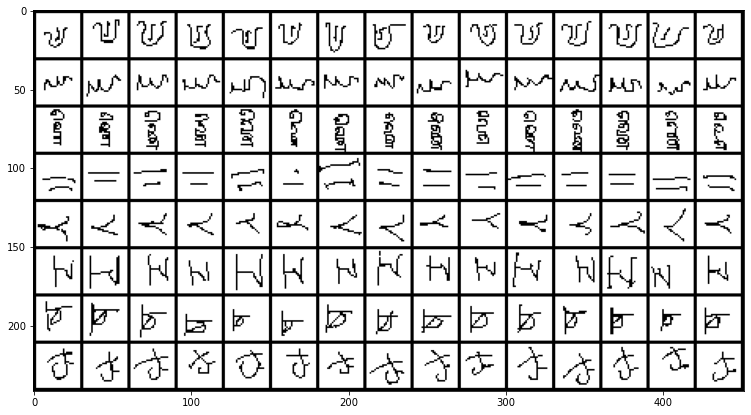

In [9]:
from matplotlib import pyplot as plt

def display_sample(sample):
  # need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  # make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

sample_example = dataloader.extract_sample(8, 10, 5, train_x, train_y)
display_sample(sample_example['images'])

In [48]:
encoder = Encoder()
model = Adaptive_Subspace(encoder)

In [51]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

n_way = 60
n_support = 5
n_query = 5

max_epoch = 10
epoch_size = 100

Train.train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, dataloader, 32)


Epoch 1 -- Loss: 3.2148 Acc: 0.9177



Epoch 2 -- Loss: 3.1931 Acc: 0.9372



Epoch 3 -- Loss: 3.1812 Acc: 0.9462



Epoch 4 -- Loss: 3.1747 Acc: 0.9532



Epoch 5 -- Loss: 3.1735 Acc: 0.9534



Epoch 6 -- Loss: 3.1694 Acc: 0.9578



Epoch 7 -- Loss: 3.1710 Acc: 0.9558



Epoch 8 -- Loss: 3.1709 Acc: 0.9557



Epoch 9 -- Loss: 3.1712 Acc: 0.9558



Epoch 10 -- Loss: 3.1708 Acc: 0.9563


In [56]:
n_way = 5
n_support = 5
n_query = 5

test_episode = 1000

Train.test(model, test_x, test_y, n_way, n_support, n_query, test_episode, dataloader, 32)


Test results -- Loss: 0.9146 Acc: 0.9905


In [ ]:
torch.save(model.state_dict(), "/kaggle/working/adaptive_subspace.h5")